In [1]:
#%%
# Section of the Python code where we import all dependencies on third party Python modules/libaries or our own
# libraries (exposed C++ code to Python, i.e. darts.engines && darts.physics)
from model_deadoil import ModelDA
import numpy as np
import meshio
from darts.engines import *

import concurrent.futures
import math
import os
import re
import shutil
import time

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
# 
m_true = ModelDA(frac_aper =1e-3)
time_range = np.arange(0,1000, 1)+1
# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).

m_true.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true.params.max_ts = 10  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true.run(time_range[-1])

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8



In [3]:
import pandas as pd
time_data = pd.DataFrame.from_dict(m_true.physics.engine.time_data)
writer = pd.ExcelWriter('m_true_time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()



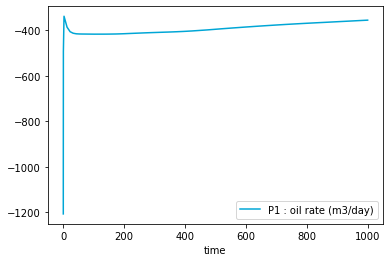

In [4]:
from darts.tools.plot_darts import *
prod = m_true.reservoir.wells[1]
inj =   m_true.reservoir.wells[0]
ax2 = plot_oil_rate_darts(prod.name, time_data)


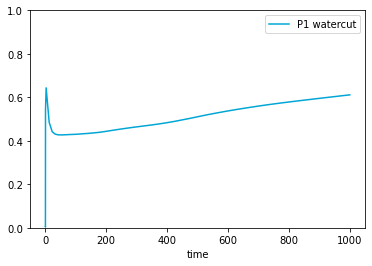

In [5]:
ax3 = plot_watercut_darts(prod.name, time_data)

In [7]:
#create a np.array that while the value of time_data['time'] is less then time_range[j], copy the value of time_data['I1 : c 1 rate (Kmol/day)'] in a new array with the same shape as time_range
#and then return the mean of the array
# data colums
columnsNameList = ['P1 : oil rate (m3/day)']
def media_function(time_range, time_data,columnsNameList):
    s=[]
    media =[]
    flag=np.zeros(len(time_data['time']))
    for j,step in enumerate(time_range):
        for i,tempo in enumerate(time_data['time']):
            if step>=tempo and flag[i]==0:
                flag[i]=1 
                s.append(time_data[columnsNameList[0]][i])
        media.append(np.mean(s))
    return media

In [21]:
#create a function that store the mean of the data in a array X of Y elements that are between two values a and b
X=[]
s=[]
if time_range[0]-1<=time_data['time'][0]<time_range[1]:

    s.append(time_data[columnsNameList[0]][0])
   
 

In [19]:
s


[-1206.9839691742168]

In [8]:
##Create hard data from true model
#obsData= -1*np.array(time_data['P1 : oil rate (m3/day)'])
obsValues = -1*np.array(media_function(time_range, time_data, columnsNameList))
dObs = obsValues.T.flatten()
dTime= np.array(time_range)

CeDiag =np.array(0.001*dObs[:]) #diagonal of the covariance matrix of observed data %1 of the oil rate
NTimesteps=len(dTime)
NWells=1
wells = ['P1']
wellDObs = np.repeat(wells, NTimesteps) #Configure the wells list


In [ ]:
#create a function that store the mean of the data in a array X of Y elements that are between two values a and b
def mean_function(a,b,data):
    X=[]
    Y=[]
    for i,tempo in enumerate(data):
        if a<=tempo<=b:
            X.append(tempo)
            Y.append(data[i])
    return np.mean(Y),np.std(Y)


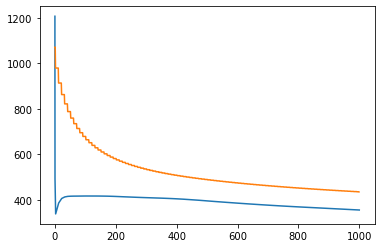

In [10]:
plt.plot(time_data['time'],-1*time_data['P1 : oil rate (m3/day)'])
plt.plot(dObs)
plt.show()



In [11]:
#create a function to run ensemble simulations based on the prior ensemble
def RunModels(destDir, MScalar):
    for i, mMScalar in enumerate(MScalar.T):
        # create a model object
        m = ModelDA(frac_aper = mMScalar);
        # initialize the model
        m.init();
        m.params.max_ts = 10
        # run the model
        start = time.time()
        m.run(time_range[1999]);
        # get the data
        time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
         # write timedata to output file
        time_data.to_pickle(f'{destDir}\\data_model'+str(i)+'.pkl')  
        end = time.time()
        print(f'Elapsed time: {end - start} for model {str(i)}')

In [20]:
#Read the result from the model
def ReadModels(destDir, columnsNameList, Nd, Ne):
    D = np.empty([Nd, Ne])
    for i in range(Ne):
        dataSet = pd.read_pickle(f'{destDir}\\data_model'+str(i)+'.pkl') 
        model_value=np.array([])
        for name in columnsNameList:
            model_value = -1*np.array(media_function(time_range, dataSet, columnsNameList))
        
        d_models = model_value.T.flatten()    
           
        D[:,i] = d_models 

    return D

In [21]:
#functions to run ES-MDA
# Finds the truncation number - if using SVD
def FindTruncationNumber(Sigma, csi):
    temp = 0
    i = 0
    svSum = np.sum(Sigma)
    stopValue = svSum * csi
    for sv in np.nditer(Sigma):
        if (temp >= stopValue):
            break
        temp += sv
        i += 1
    return i

#Series of matriz treatments to make the process less memory consuming  - 
# see  Evensen, G., The Ensemble Kalman Filter: Theoretical Formulation and Practical Implementation, Ocean Dynamics (2003)
def CentralizeMatrix(M):
    meanMatrix = np.mean(M, axis=0)
    return M - meanMatrix


def UpdateModelLocalized(M, Psi, R, DobsD):
    DeltaM = CentralizeMatrix(M)

    K = DeltaM @ Psi
    Kloc = R * K ## Kalman gain with localization 
    return M + Kloc @ DobsD 

def UpdateModel(M, Psi, DobsD):
    DeltaM = CentralizeMatrix(M)

    X10 = Psi @ DobsD
    return M + DeltaM @ X10

In [22]:
#%%
#Calculate objetive function
def calcDataMismatchObjectiveFunction(dObs, D, CeInv):
    Ne = D.shape[1]
    Nd = D.shape[0]

    Od = np.empty(Ne)
    for i in range(Ne):
        dObsD = dObs - D[:,i].reshape(Nd,1)
        Od[i] = (dObsD.T) @ (CeInv[:,np.newaxis] * dObsD)/2
    return Od

# Replaces the pattern with the value in array cosrresponding its position.
# Only 1 group per line for now...
def ReplacePattern(matchobj, array):
    return f'{array[int(matchobj.group(1))]:.2f}'

In [36]:
#Building the prior ensemble based only on frac_aper 
# problem dimensions
#Ni = m_true.nx
#Nj = m_true.ny
NGrid = 0 # Ni * Nj
NScalar = 1 #we just considering one scalar as the parameter in the problem
Nm = NGrid + NScalar
Nd = len(dTime)* 1 #  timesteps * 1 well data
Ne = 25
NTimesteps = len(dTime)
NWells = 1 #we just considering one well

# svd truncation parameter for SVD 
csi = 0.99

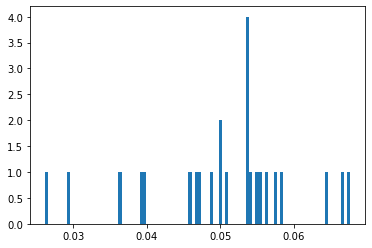

'c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1'

In [37]:
#%%
#Generate the prior ensemble of scalar parameters
# build random values for fraction of aperture using normal distribution and fract_aper of the true model as mean as mean and 10% as std with seed=1
Em_frac_aper = np.clip(np.random.normal(0.05, 0.01, Ne),0.0005,0.1) #cliping to keep only positive numbvers for the frac apertures 

# data colums
columnsNameList = ['P1 : oil rate (m3/day)']

MScalarPrior = Em_frac_aper
#print MScalarPrioir histogram
plt.hist(MScalarPrior, bins=100)
plt.show()
#%%
curDir = os.getcwd()
srcDir =  f'{curDir}'
srcDir

In [39]:
#create a function to run ensemble simulations based on the prior ensemble
for i, mMScalar in enumerate(MScalarPrior):
   
   print(i)
   print(mMScalar)
   


   

0
0.05373028869605234
1
0.05096553259743294
2
0.05742988630213643
3
0.06656112602393996
4
0.026234228101577085
5
0.02943558608128376
6
0.04729797873368415
7
0.05385407398399922
8
0.03650420041796533
9
0.05376846536098865
10
0.055277829730948684
11
0.03959802723570916
12
0.055105130200376454
13
0.05011394540921798
14
0.03933043190674919
15
0.046019435785188134
16
0.056065174956049006
17
0.0584686900991363
18
0.05021391661671524
19
0.04655383471252038
20
0.06461843515935621
21
0.05409824551079024
22
0.05380437501167639
23
0.06760371931504261
24
0.048736221953605385


In [40]:
# %%
#Run ES-MDA
SDiag = np.sqrt(CeDiag)
SInvDiag = np.power(SDiag, -1)

INd = np.eye(Nd)

MGrid = [] #not considering grid parameters
MScalar = MScalarPrior

alphas = [4., 4., 4., 4.]
l = 0
for alpha in alphas:
    # 2. Forecast

    # Generates the perturbed observations 
    z = np.random.normal(size=(Nd,Ne))
    DPObs = dObs[:,np.newaxis] + math.sqrt(alpha) * CeDiag[:,np.newaxis] * z

    # Run the simulations g(M) 
    destDir = f'{curDir}\\simulations_deadoil\\it{l}'
    RunModels(destDir, MScalar)
    D = ReadModels(destDir, columnsNameList, Nd, Ne)
    if (l == 0):
        DPrior = D

    DobsD = DPObs - D

    # 4. Analysis
    # 4.1 Invert matrix C

    # Calculates DeltaD (12.5)
    meanMatrix = np.mean(D, axis=1)
    DeltaD = D - meanMatrix[:,np.newaxis]

    # Calculates CHat (12.10)
    CHat = SInvDiag[:,np.newaxis] * ( DeltaD @ DeltaD.T ) * SInvDiag[np.newaxis,:] + alpha * (Ne - 1) * INd

    # Calculates Gamma and X (12.18)
    U, SigmaDiag, Vt = np.linalg.svd(CHat)
    Nr = FindTruncationNumber(SigmaDiag, csi)

    GammaDiag = np.power(SigmaDiag[0:Nr], -1)
    X = SInvDiag[:,np.newaxis] * U[:,0:Nr]

    # Calculates M^a (12.21)
    X1 = GammaDiag[:,np.newaxis] * X.T
    X8 = DeltaD.T @ X
    X9 = X8 @ X1
    
    # subpart: for grid, use localization
    #MGrid = UpdateModelLocalized(MGrid, X9, Rmd, DobsD)

    # subpart: for scalars, don't use localization
    
    MScalar = UpdateModel(MScalar, X9, DobsD)
    MScalar[:] = np.clip(MScalar[:], 0.0005,0.1)
    for i, mMScalar in enumerate(MScalar):
     print(i)
     print(mMScalar)
   
    l += 1
#%%
#MGridPost = MGrid
MScalarPost = MScalar
DPost = D



darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 15.120505809783936 for model 0
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 15.070611953735352 for model 1
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 16.533860206604004 for model 2
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 15.53621792793274 for model 3
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 17.36869740486145 for model 4
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 16.315854787826538 for model 5
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 16.33400559425354 for model 6
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 16.56488585472107 for model 7
darts-package built on 27/03/2022 15:20:27 b

In [31]:
destDir

'c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1\\simulations_deadoil\\it3'

Mean: prior=2.044e+12, post=2.454e+08
Std: prior=2.032e+11, post=0.000e+00


Text(0.5, 1.0, 'Histograms Objetive Functions')

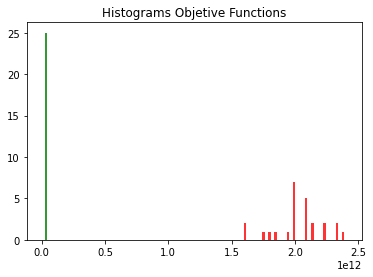

In [41]:
#%%
# Comparison of data mismatch objective function
# prior (l = 0)
CeInv = np.power(CeDiag, -1)
OPrior = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPrior, CeInv)
OPost = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPost, CeInv)

print(f'Mean: prior={np.mean(OPrior):.3e}, post={np.mean(OPost):.3e}')
print(f'Std: prior={np.std(OPrior, ddof=1):.3e}, post={np.std(OPost, ddof=1):.3e}')

fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((OPrior, OPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Objetive Functions')

Mean: prior=5.046e-02, post=5.000e-04
Std: prior=1.023e-02, post=0.000e+00


Text(0.5, 1.0, 'Histograms Fracture Apertures before and after history matching')

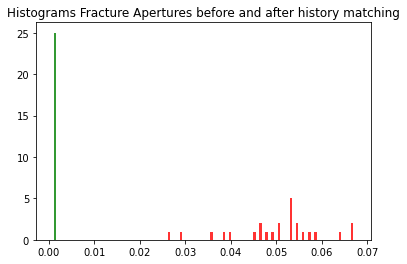

In [42]:
#Compare  the histograms of frac_aper prior and post

print(f'Mean: prior={np.mean(MScalarPrior):.3e}, post={np.mean(MScalarPost):.3e}')
print(f'Std: prior={np.std(MScalarPrior, ddof=1):.3e}, post={np.std(MScalarPost, ddof=1):.3e}')


fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((MScalarPrior, MScalarPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Fracture Apertures before and after history matching')



IndexError: list index out of range

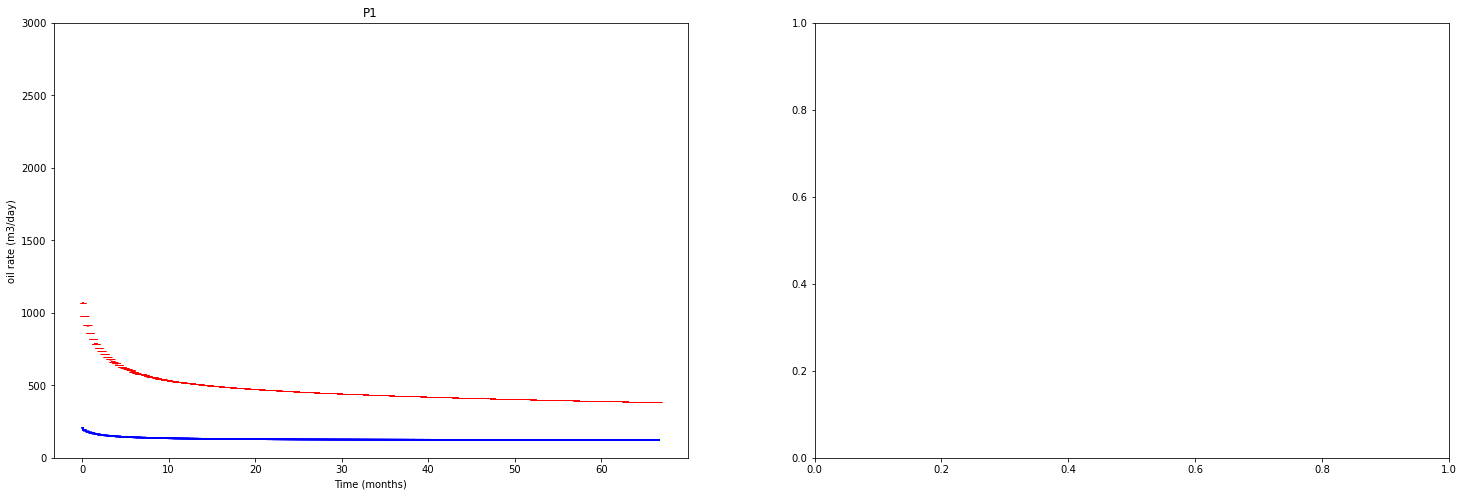

In [45]:
#%%
# Split the data into data array
wellDataPriorArray = np.split(DPrior, NWells)
wellDataPostArray = np.split(DPost, NWells)
wellDataObsArray = np.split(dObs, NWells)
wellDataObsErrorArray = np.split(CeDiag, NWells)

wellSubtitle = ['P1']
timeMonths = dTime/30.0


# get data and store in an array
prior = wellDataPriorArray # wellDataPriorArray[0:11:2]
post = wellDataPostArray # wellDataPostArray[0:11:2]
plotObsData = wellDataObsArray #wellDataObsArray[0:11:2]
errObsData = wellDataObsErrorArray #wellDataObsErrorArray[0:11:2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[0].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[0].errorbar(timeMonths, plotObsData[0], yerr=errObsData[0], fmt='_ r', capthick=1, capsize=0.1)
#axFlat[0].plot(timeMonths, plotObsData[i],color='red', alpha=0.5)
axFlat[0].set_title(wellSubtitle[0])
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('oil rate (m3/day)')
axFlat[0].set_ylim([0, 3000])


axFlat[1].plot(timeMonths, prior[1], color='#00FFFF', alpha=0.3)
axFlat[1].plot(timeMonths, post[1], color='b', alpha=0.3)
axFlat[1].scatter(timeMonths, plotObsData[1],color='red', alpha=0.5)
axFlat[1].set_title(wellSubtitle[0])
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('oil rate (m3/day)')
#axFlat[1].set_ylim([342, 348])
fig.suptitle('P1 : oil rate (m3/day)')


In [1]:
!jupyter nbconvert --to html mainDA_explained.ipynb

[NbConvertApp] Converting notebook mainDA_explained.ipynb to html
[NbConvertApp] Writing 701465 bytes to mainDA_explained.html


Evaluating the Water Rate Results

In [155]:
vazao = ['P1 : water rate (m3/day)']
#Read the result of the posterior
D_qw = ReadModels(destDir, vazao, Nd, Ne)*(-1)
#Read the result of the prior
Prior = 20
D_qw_prior = ReadModels('simulations\it0', vazao, Nd, Prior)*(-1)

#Read the reference data 
obsData_qw= np.array(time_data['P1 : water rate (m3/day)'])
obsValues_qw = np.array(obsData_qw)*(-1)
dObs_qw = obsValues_qw.T.flatten()
CeDiag_qw =np.array(0.001*dObs_qw[:]) #diagonal of the covariance matrix of observed data %1 of the water rate



Text(0.5, 0.98, 'P1 : water rate (m3/day)')

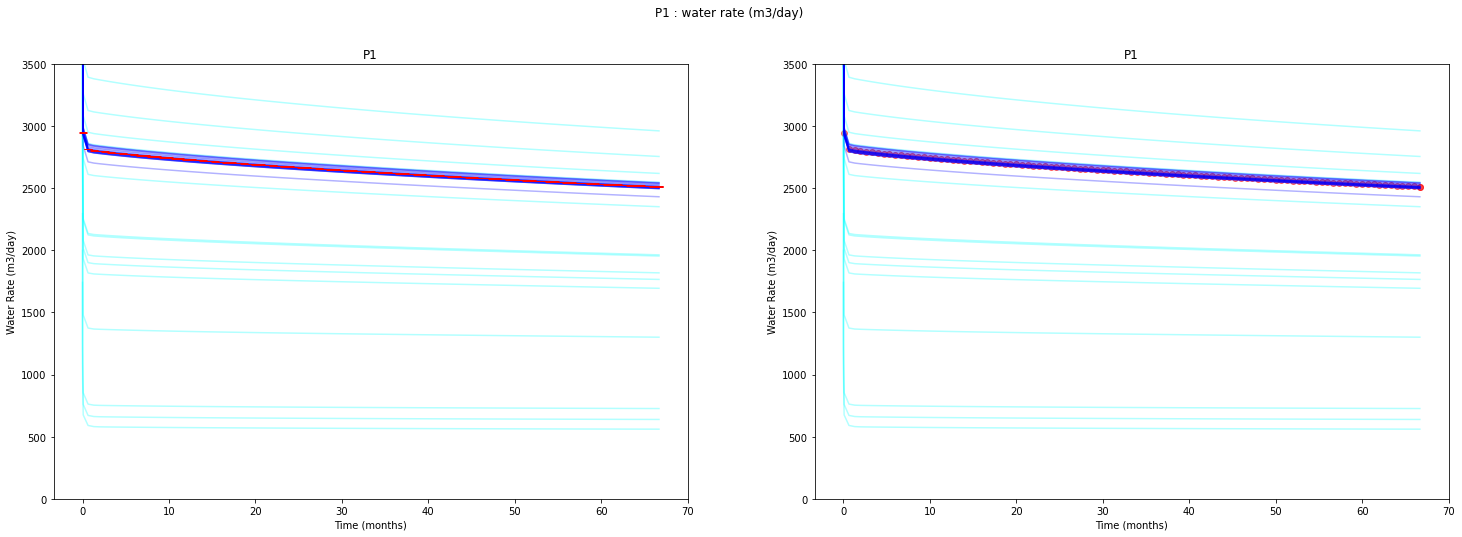

In [162]:
#%%
# Split the data into data array
wellDataPriorArray = np.split(D_qw_prior, NWells)
wellDataPostArray = np.split(D_qw, NWells)
wellDataObsArray = np.split(dObs_qw, NWells)
wellDataObsErrorArray = np.split(CeDiag_qw, NWells)

wellSubtitle = ['P1']
timeMonths = dTime/30.0


# get data and store in an array
prior = wellDataPriorArray # wellDataPriorArray[0:11:2]
post = wellDataPostArray # wellDataPostArray[0:11:2]
plotObsData = wellDataObsArray #wellDataObsArray[0:11:2]
errObsData = wellDataObsErrorArray #wellDataObsErrorArray[0:11:2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[0].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[0].errorbar(timeMonths, plotObsData[0], yerr=errObsData[i], fmt='_ r', capthick=1, capsize=4)
#axFlat[0].plot(timeMonths, plotObsData[i],color='red', alpha=0.5)
axFlat[0].set_title(wellSubtitle[0])
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('Water Rate (m3/day)')
axFlat[0].set_ylim([0, 3500])

axFlat[1].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[1].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[1].scatter(timeMonths, plotObsData[0],color='red', alpha=0.5)
axFlat[1].set_title(wellSubtitle[0])
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('Water Rate (m3/day)')
axFlat[1].set_ylim([0, 3500])
fig.suptitle('P1 : water rate (m3/day)')



Mean: prior=8.654e+07, post=1.637e+04
Std: prior=1.268e+08, post=4.385e+04


Text(0.5, 1.0, 'Histograms Objetive Functions for water rate')

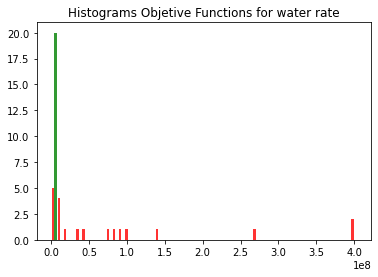

In [164]:
#%%
# Comparison of data mismatch objective function
CeInv_qw = np.power(CeDiag_qw, -1)
OPrior_qw = calcDataMismatchObjectiveFunction(dObs_qw[:,np.newaxis],D_qw_prior, CeInv_qw)
OPost_qw = calcDataMismatchObjectiveFunction(dObs_qw[:,np.newaxis],D_qw, CeInv_qw)
print(f'Mean: prior={np.mean(OPrior_qw):.3e}, post={np.mean(OPost_qw):.3e}')
print(f'Std: prior={np.std(OPrior_qw, ddof=1):.3e}, post={np.std(OPost_qw, ddof=1):.3e}')

fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((OPrior_qw, OPost_qw), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Objetive Functions for water rate')